In [64]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [65]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [66]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [67]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [68]:
Scaler = StandardScaler()
x_tabular = Scaler.fit_transform(tabular_features)
y = labels.values

In [69]:
height, width = 256, 256 
batch_size=16

In [70]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [71]:
# testing part
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [72]:
# y = labels.values if hasattr(labels, "values") else labels

# X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
#     X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
# )
# print("Training samples:", X_img_train.shape[0])
# print("Validation samples:", X_img_val.shape[0])


In [ ]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_7       │ (None, 256, 256,  │          0 │ input_layer_26[0… │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_7   │ (None, 256, 256,  │          0 │ random_flip_7[0]… │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_7       │ (None, 256, 256,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │        320 │ random_zoom_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_39 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 85, 85,    │          0 │ re_lu_39[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 85, 85,    │     18,496 │ max_pooling2d_26… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_40 (ReLU)     │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 128)       │     51,328 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 28, 28,    │          0 │ re_lu_40[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_66[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_27… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_41 (ReLU)     │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 91,777 (358.50 KB)

 Trainable params: 91,329 (356.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [108]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [109]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4411 - loss: 0.8375
Epoch 1: val_loss improved from None to 0.76977, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.3977 - loss: 0.8094 - val_accuracy: 0.5500 - val_loss: 0.7698
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.4502 - loss: 0.7721
Epoch 2: val_loss improved from 0.76977 to 0.76230, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.4432 - loss: 0.7775 - val_accuracy: 0.5500 - val_loss: 0.7623
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5667 - loss: 0.7481
Epoch 3: val_loss improved from 0.76230 to 0.75773, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.5795 - loss: 0.7544 - val_accuracy: 0.5000 - val_loss: 0.7577
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5855 - loss: 0.7399
Epoch 4: val_loss improved from 0.75773 to 0.75755, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5682 - loss: 0.7927 - val_accuracy: 0.5000 - val_loss: 0.7575
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.5614 - loss: 0.7311
Epoch 5: val_loss did not improve from 0.75755
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.5227 - loss: 0.7392 - val_accuracy: 0.4500 - val_loss: 0.7591
Epoch 6/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4444 - loss: 0.7713
Epoch 6: val_loss improved from 0.75755 to 0.74988, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.4886 - loss: 0.7374 - val_accuracy: 0.4500 - val_loss: 0.7499
Epoch 7/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5868 - loss: 0.6784
Epoch 7: val_loss improved from 0.74988 to 0.74248, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.5795 - loss: 0.7025 - val_accuracy: 0.4500 - val_loss: 0.7425
Epoch 8/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.4703 - loss: 0.7571
Epoch 8: val_loss improved from 0.74248 to 0.73688, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5114 - loss: 0.7289 - val_accuracy: 0.4500 - val_loss: 0.7369
Epoch 9/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.4291 - loss: 0.7813
Epoch 9: val_loss improved from 0.73688 to 0.73052, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.4205 - loss: 0.7978 - val_accuracy: 0.4000 - val_loss: 0.7305
Epoch 10/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5741 - loss: 0.7326
Epoch 10: val_loss improved from 0.73052 to 0.72654, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6136 - loss: 0.7276 - val_accuracy: 0.4000 - val_loss: 0.7265
Epoch 11/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5561 - loss: 0.7004
Epoch 11: val_loss improved from 0.72654 to 0.72283, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5909 - loss: 0.7106 - val_accuracy: 0.4500 - val_loss: 0.7228
Epoch 12/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6151 - loss: 0.6721
Epoch 12: val_loss improved from 0.72283 to 0.72020, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.6136 - loss: 0.6694 - val_accuracy: 0.4000 - val_loss: 0.7202
Epoch 13/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6153 - loss: 0.6766
Epoch 13: val_loss improved from 0.72020 to 0.71802, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6250 - loss: 0.6871 - val_accuracy: 0.4000 - val_loss: 0.7180
Epoch 14/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5800 - loss: 0.6688
Epoch 14: val_loss improved from 0.71802 to 0.71604, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.5455 - loss: 0.7017 - val_accuracy: 0.4000 - val_loss: 0.7160
Epoch 15/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6353 - loss: 0.6795
Epoch 15: val_loss improved from 0.71604 to 0.71003, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.5682 - loss: 0.7164 - val_accuracy: 0.4500 - val_loss: 0.7100
Epoch 16/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6481 - loss: 0.6316
Epoch 16: val_loss improved from 0.71003 to 0.70532, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6477 - loss: 0.6358 - val_accuracy: 0.6000 - val_loss: 0.7053
Epoch 17/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6320 - loss: 0.6562
Epoch 17: val_loss improved from 0.70532 to 0.70408, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.7045 - loss: 0.6294 - val_accuracy: 0.6000 - val_loss: 0.7041
Epoch 18/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7235 - loss: 0.6163
Epoch 18: val_loss improved from 0.70408 to 0.69727, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.6818 - loss: 0.6474 - val_accuracy: 0.6000 - val_loss: 0.6973
Epoch 19/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6624 - loss: 0.6625
Epoch 19: val_loss improved from 0.69727 to 0.69483, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.6477 - loss: 0.6602 - val_accuracy: 0.5500 - val_loss: 0.6948
Epoch 20/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5667 - loss: 0.6620
Epoch 20: val_loss improved from 0.69483 to 0.68978, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5227 - loss: 0.7104 - val_accuracy: 0.5500 - val_loss: 0.6898
Epoch 21/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6004 - loss: 0.6809
Epoch 21: val_loss improved from 0.68978 to 0.68141, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.6364 - loss: 0.6697 - val_accuracy: 0.5500 - val_loss: 0.6814
Epoch 22/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6429 - loss: 0.7155
Epoch 22: val_loss improved from 0.68141 to 0.67745, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.6250 - loss: 0.6885 - val_accuracy: 0.5500 - val_loss: 0.6774
Epoch 23/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6577 - loss: 0.6284
Epoch 23: val_loss improved from 0.67745 to 0.67087, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7273 - loss: 0.6044 - val_accuracy: 0.5500 - val_loss: 0.6709
Epoch 24/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5356 - loss: 0.7077
Epoch 24: val_loss improved from 0.67087 to 0.66352, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5909 - loss: 0.6739 - val_accuracy: 0.5500 - val_loss: 0.6635
Epoch 25/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6151 - loss: 0.6630
Epoch 25: val_loss improved from 0.66352 to 0.65710, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.6023 - loss: 0.6519 - val_accuracy: 0.5500 - val_loss: 0.6571
Epoch 26/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6298 - loss: 0.6542
Epoch 26: val_loss did not improve from 0.65710
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.5909 - loss: 0.6997 - val_accuracy: 0.5500 - val_loss: 0.6583
Epoch 27/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6777 - loss: 0.6302
Epoch 27: val_loss did not improve from 0.65710
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6250 - loss: 0.6620 - val_accuracy: 0.5500 - val_loss: 0.6612
Epoch 28/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6863 - loss: 0.6185
Epoch 28: val_loss did not improve from 0.65710
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.7500 - loss: 0.6051 - val_accuracy: 0.5500 - val_loss: 0.6589
Epoch 29/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6736 - loss: 0.5851
Epoch 29: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.7614 - loss: 0.6017 - val_accuracy: 0.5500 - val_loss: 0.6563
Epoch 31/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6616 - loss: 0.6858
Epoch 31: val_loss improved from 0.65630 to 0.65120, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.6818 - loss: 0.6391 - val_accuracy: 0.6000 - val_loss: 0.6512
Epoch 32/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6064 - loss: 0.6713
Epoch 32: val_loss did not improve from 0.65120
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6136 - loss: 0.6770 - val_accuracy: 0.6000 - val_loss: 0.6521
Epoch 33/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6880 - loss: 0.6050
Epoch 33: val_loss improved from 0.65120 to 0.65007, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.7159 - loss: 0.6012 - val_accuracy: 0.6000 - val_loss: 0.6501
Epoch 34/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6263 - loss: 0.7099
Epoch 34: val_loss did not improve from 0.65007
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6477 - loss: 0.6633 - val_accuracy: 0.6500 - val_loss: 0.6513
Epoch 35/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6614 - loss: 0.6755
Epoch 35: val_loss improved from 0.65007 to 0.64736, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.6477 - loss: 0.6442 - val_accuracy: 0.6500 - val_loss: 0.6474
Epoch 36/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5810 - loss: 0.6889
Epoch 36: val_loss did not improve from 0.64736
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.6023 - loss: 0.6882 - val_accuracy: 0.6500 - val_loss: 0.6488
Epoch 37/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6992 - loss: 0.6100
Epoch 37: val_loss improved from 0.64736 to 0.64441, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.6477 - loss: 0.6596 - val_accuracy: 0.6500 - val_loss: 0.6444
Epoch 38/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7532 - loss: 0.5881
Epoch 38: val_loss improved from 0.64441 to 0.63825, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.7614 - loss: 0.5917 - val_accuracy: 0.6500 - val_loss: 0.6383
Epoch 39/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6575 - loss: 0.6239
Epoch 39: val_loss improved from 0.63825 to 0.63562, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.6932 - loss: 0.6093 - val_accuracy: 0.6500 - val_loss: 0.6356
Epoch 40/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.8355 - loss: 0.5243
Epoch 40: val_loss improved from 0.63562 to 0.63495, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step - accuracy: 0.7614 - loss: 0.5890 - val_accuracy: 0.6500 - val_loss: 0.6349
Epoch 41/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5757 - loss: 0.6753
Epoch 41: val_loss improved from 0.63495 to 0.63483, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.6364 - loss: 0.6303 - val_accuracy: 0.6500 - val_loss: 0.6348
Epoch 42/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6690 - loss: 0.6446
Epoch 42: val_loss improved from 0.63483 to 0.63358, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.6818 - loss: 0.6188 - val_accuracy: 0.6500 - val_loss: 0.6336
Epoch 43/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7051 - loss: 0.6178
Epoch 43: val_loss did not improve from 0.63358
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.7045 - loss: 0.6236 - val_accuracy: 0.6500 - val_loss: 0.6341
Epoch 44/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7137 - loss: 0.6118
Epoch 44: val_loss did not improve from 0.63358
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 308ms/step - accuracy: 0.7045 - loss: 0.6122 - val_accuracy: 0.6500 - val_loss: 0.6337
Epoch 45/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8129 - loss: 0.5387
Epoch 45: val_loss did not improve from 0.63358
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.7500 - loss: 0.5535 - val_accuracy: 0.6000 - val_loss: 0.6339
Epoch 46/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.6661 - loss: 0.6009
Epoch 46: val_loss did not improv

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.7386 - loss: 0.5491 - val_accuracy: 0.6500 - val_loss: 0.6326
Epoch 51/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7444 - loss: 0.5956
Epoch 51: val_loss improved from 0.63259 to 0.63020, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.7500 - loss: 0.5863 - val_accuracy: 0.6500 - val_loss: 0.6302
Epoch 52/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7080 - loss: 0.5733
Epoch 52: val_loss improved from 0.63020 to 0.62686, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.7500 - loss: 0.5631 - val_accuracy: 0.6500 - val_loss: 0.6269
Epoch 53/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6766 - loss: 0.5564
Epoch 53: val_loss improved from 0.62686 to 0.61898, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.6477 - loss: 0.5872 - val_accuracy: 0.6500 - val_loss: 0.6190
Epoch 54/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7138 - loss: 0.6222
Epoch 54: val_loss improved from 0.61898 to 0.60806, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.7614 - loss: 0.5740 - val_accuracy: 0.7000 - val_loss: 0.6081
Epoch 55/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7597 - loss: 0.5219
Epoch 55: val_loss improved from 0.60806 to 0.60559, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.7386 - loss: 0.5325 - val_accuracy: 0.7000 - val_loss: 0.6056
Epoch 56/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7924 - loss: 0.5482
Epoch 56: val_loss improved from 0.60559 to 0.60372, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.7727 - loss: 0.5772 - val_accuracy: 0.7000 - val_loss: 0.6037
Epoch 57/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7799 - loss: 0.5262
Epoch 57: val_loss did not improve from 0.60372
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.7273 - loss: 0.5550 - val_accuracy: 0.7000 - val_loss: 0.6076
Epoch 58/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.5594 - loss: 0.6977
Epoch 58: val_loss did not improve from 0.60372
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.6250 - loss: 0.6474 - val_accuracy: 0.7000 - val_loss: 0.6057
Epoch 59/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.7157 - loss: 0.6282
Epoch 59: val_loss did not improve from 0.60372
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 304ms/step - accuracy: 0.7045 - loss: 0.6254 - val_accuracy: 0.7000 - val_loss: 0.6081
Epoch 60/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7516 - loss: 0.5737
Epoch 60: val_loss did not improve f

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.6818 - loss: 0.6071 - val_accuracy: 0.7000 - val_loss: 0.6009
Epoch 65/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8144 - loss: 0.5544
Epoch 65: val_loss improved from 0.60089 to 0.59575, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.7841 - loss: 0.5441 - val_accuracy: 0.7000 - val_loss: 0.5958
Epoch 66/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8111 - loss: 0.5010
Epoch 66: val_loss improved from 0.59575 to 0.59154, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.7614 - loss: 0.5440 - val_accuracy: 0.7000 - val_loss: 0.5915
Epoch 67/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8566 - loss: 0.4958
Epoch 67: val_loss improved from 0.59154 to 0.58370, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.8182 - loss: 0.5344 - val_accuracy: 0.7000 - val_loss: 0.5837
Epoch 68/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8261 - loss: 0.5300
Epoch 68: val_loss improved from 0.58370 to 0.58342, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - accuracy: 0.7727 - loss: 0.5125 - val_accuracy: 0.7500 - val_loss: 0.5834
Epoch 69/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8322 - loss: 0.5006
Epoch 69: val_loss did not improve from 0.58342
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.7955 - loss: 0.5298 - val_accuracy: 0.7500 - val_loss: 0.5856
Epoch 70/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6970 - loss: 0.5725
Epoch 70: val_loss did not improve from 0.58342
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.7045 - loss: 0.5762 - val_accuracy: 0.7500 - val_loss: 0.5889
Epoch 71/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8133 - loss: 0.5123
Epoch 71: val_loss did not improve from 0.58342
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.7273 - loss: 0.5396 - val_accuracy: 0.7500 - val_loss: 0.5908
Epoch 72/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.7637 - loss: 0.5042
Epoch 72: val_loss did not improve

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step - accuracy: 0.7614 - loss: 0.5042 - val_accuracy: 0.7500 - val_loss: 0.5818
Epoch 75/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8094 - loss: 0.4981
Epoch 75: val_loss did not improve from 0.58180
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step - accuracy: 0.7500 - loss: 0.5141 - val_accuracy: 0.7500 - val_loss: 0.5848
Epoch 76/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.7881 - loss: 0.5083
Epoch 76: val_loss did not improve from 0.58180
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.8068 - loss: 0.5101 - val_accuracy: 0.7000 - val_loss: 0.5916
Epoch 77/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8114 - loss: 0.4997
Epoch 77: val_loss did not improve from 0.58180
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.8068 - loss: 0.5029 - val_accuracy: 0.7000 - val_loss: 0.5993
Epoch 78/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8107 - loss: 0.5014
Epoch 78: val_loss did not improve 

22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - accuracy: 0.7045 - loss: 0.5524 - val_accuracy: 0.7500 - val_loss: 0.5809
Epoch 81/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7248 - loss: 0.5362
Epoch 81: val_loss improved from 0.58094 to 0.57390, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.7614 - loss: 0.5185 - val_accuracy: 0.7500 - val_loss: 0.5739
Epoch 82/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7694 - loss: 0.4709
Epoch 82: val_loss improved from 0.57390 to 0.57233, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 449ms/step - accuracy: 0.7614 - loss: 0.5013 - val_accuracy: 0.7500 - val_loss: 0.5723
Epoch 83/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8017 - loss: 0.4887
Epoch 83: val_loss did not improve from 0.57233
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 409ms/step - accuracy: 0.7955 - loss: 0.4697 - val_accuracy: 0.7000 - val_loss: 0.5774
Epoch 84/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7947 - loss: 0.5422
Epoch 84: val_loss did not improve from 0.57233
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.7614 - loss: 0.5234 - val_accuracy: 0.7000 - val_loss: 0.5850
Epoch 85/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7656 - loss: 0.5152
Epoch 85: val_loss improved from 0.57233 to 0.57143, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step - accuracy: 0.7727 - loss: 0.4916 - val_accuracy: 0.7500 - val_loss: 0.5714
Epoch 86/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7532 - loss: 0.5468
Epoch 86: val_loss did not improve from 0.57143
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.7614 - loss: 0.5180 - val_accuracy: 0.7500 - val_loss: 0.5740
Epoch 87/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8619 - loss: 0.4106
Epoch 87: val_loss improved from 0.57143 to 0.56725, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 444ms/step - accuracy: 0.8409 - loss: 0.4237 - val_accuracy: 0.7500 - val_loss: 0.5673
Epoch 88/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8372 - loss: 0.4264
Epoch 88: val_loss improved from 0.56725 to 0.56188, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8182 - loss: 0.4471 - val_accuracy: 0.7500 - val_loss: 0.5619
Epoch 89/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7350 - loss: 0.5729
Epoch 89: val_loss improved from 0.56188 to 0.56134, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step - accuracy: 0.7727 - loss: 0.5126 - val_accuracy: 0.7500 - val_loss: 0.5613
Epoch 90/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8182 - loss: 0.4455
Epoch 90: val_loss improved from 0.56134 to 0.55933, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.8182 - loss: 0.4356 - val_accuracy: 0.7500 - val_loss: 0.5593
Epoch 91/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8811 - loss: 0.4420
Epoch 91: val_loss did not improve from 0.55933
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 431ms/step - accuracy: 0.8409 - loss: 0.4793 - val_accuracy: 0.7500 - val_loss: 0.5607
Epoch 92/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7805 - loss: 0.5046
Epoch 92: val_loss improved from 0.55933 to 0.55161, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.8182 - loss: 0.4710 - val_accuracy: 0.7500 - val_loss: 0.5516
Epoch 93/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8599 - loss: 0.4725
Epoch 93: val_loss did not improve from 0.55161
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - accuracy: 0.8864 - loss: 0.4279 - val_accuracy: 0.7500 - val_loss: 0.5553
Epoch 94/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8439 - loss: 0.4809
Epoch 94: val_loss improved from 0.55161 to 0.54667, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8182 - loss: 0.4696 - val_accuracy: 0.7500 - val_loss: 0.5467
Epoch 95/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.7832 - loss: 0.4178
Epoch 95: val_loss improved from 0.54667 to 0.54599, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 462ms/step - accuracy: 0.7841 - loss: 0.4562 - val_accuracy: 0.7500 - val_loss: 0.5460
Epoch 96/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7485 - loss: 0.4891
Epoch 96: val_loss did not improve from 0.54599
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.8068 - loss: 0.5143 - val_accuracy: 0.7500 - val_loss: 0.5474
Epoch 97/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8065 - loss: 0.4593
Epoch 97: val_loss improved from 0.54599 to 0.54099, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - accuracy: 0.8182 - loss: 0.4581 - val_accuracy: 0.7500 - val_loss: 0.5410
Epoch 98/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9313 - loss: 0.3657
Epoch 98: val_loss did not improve from 0.54099
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 403ms/step - accuracy: 0.8523 - loss: 0.4508 - val_accuracy: 0.7500 - val_loss: 0.5414
Epoch 99/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8359 - loss: 0.3736
Epoch 99: val_loss did not improve from 0.54099
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.8068 - loss: 0.4047 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 100/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7890 - loss: 0.4453
Epoch 100: val_loss improved from 0.54099 to 0.54082, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 512ms/step - accuracy: 0.7955 - loss: 0.4376 - val_accuracy: 0.7500 - val_loss: 0.5408
Epoch 101/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8038 - loss: 0.4832
Epoch 101: val_loss improved from 0.54082 to 0.53192, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 396ms/step - accuracy: 0.7955 - loss: 0.4516 - val_accuracy: 0.7500 - val_loss: 0.5319
Epoch 102/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9087 - loss: 0.3511
Epoch 102: val_loss did not improve from 0.53192
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.8636 - loss: 0.4128 - val_accuracy: 0.7500 - val_loss: 0.5330
Epoch 103/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9010 - loss: 0.3375
Epoch 103: val_loss did not improve from 0.53192
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.8182 - loss: 0.4258 - val_accuracy: 0.7500 - val_loss: 0.5336
Epoch 104/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9140 - loss: 0.3506
Epoch 104: val_loss did not improve from 0.53192
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 395ms/step - accuracy: 0.8864 - loss: 0.3858 - val_accuracy: 0.7500 - val_loss: 0.5352
Epoch 105/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7459 - loss: 0.4412
Epoch 105: val_loss did n

22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.9091 - loss: 0.3510 - val_accuracy: 0.7500 - val_loss: 0.5311
Epoch 107/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8341 - loss: 0.4091
Epoch 107: val_loss improved from 0.53111 to 0.52683, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 420ms/step - accuracy: 0.8636 - loss: 0.4055 - val_accuracy: 0.7500 - val_loss: 0.5268
Epoch 108/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8917 - loss: 0.4146
Epoch 108: val_loss did not improve from 0.52683
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.8523 - loss: 0.4561 - val_accuracy: 0.7500 - val_loss: 0.5295
Epoch 109/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7609 - loss: 0.5396
Epoch 109: val_loss did not improve from 0.52683
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.7841 - loss: 0.4973 - val_accuracy: 0.7500 - val_loss: 0.5321
Epoch 110/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7407 - loss: 0.5065
Epoch 110: val_loss did not improve from 0.52683
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 360ms/step - accuracy: 0.7955 - loss: 0.4471 - val_accuracy: 0.7500 - val_loss: 0.5280
Epoch 111/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8417 - loss: 0.4075
Epoch 111: val_loss improve

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - accuracy: 0.8409 - loss: 0.4012 - val_accuracy: 0.7500 - val_loss: 0.5232
Epoch 112/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8764 - loss: 0.3973
Epoch 112: val_loss did not improve from 0.52316
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - accuracy: 0.8295 - loss: 0.4323 - val_accuracy: 0.7500 - val_loss: 0.5252
Epoch 113/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7158 - loss: 0.5612
Epoch 113: val_loss did not improve from 0.52316
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.7386 - loss: 0.5299 - val_accuracy: 0.8000 - val_loss: 0.5311
Epoch 114/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7475 - loss: 0.5034
Epoch 114: val_loss did not improve from 0.52316
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.7727 - loss: 0.4827 - val_accuracy: 0.7500 - val_loss: 0.5306
Epoch 115/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8116 - loss: 0.5125
Epoch 115: val_loss did not 

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 0.7614 - loss: 0.4888 - val_accuracy: 0.7500 - val_loss: 0.5231
Epoch 120/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7699 - loss: 0.4721
Epoch 120: val_loss did not improve from 0.52312
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.8068 - loss: 0.4438 - val_accuracy: 0.7500 - val_loss: 0.5267
Epoch 121/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9369 - loss: 0.3242
Epoch 121: val_loss did not improve from 0.52312
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step - accuracy: 0.9091 - loss: 0.3379 - val_accuracy: 0.7500 - val_loss: 0.5273
Epoch 122/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8582 - loss: 0.3849
Epoch 122: val_loss did not improve from 0.52312
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7955 - loss: 0.4409 - val_accuracy: 0.7500 - val_loss: 0.5261
Epoch 123/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8822 - loss: 0.3761
Epoch 123: val_loss did not 

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.8750 - loss: 0.3604 - val_accuracy: 0.7500 - val_loss: 0.5215
Epoch 129/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8394 - loss: 0.3953
Epoch 129: val_loss did not improve from 0.52148
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 381ms/step - accuracy: 0.8523 - loss: 0.3656 - val_accuracy: 0.7500 - val_loss: 0.5217
Epoch 130/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9343 - loss: 0.3031
Epoch 130: val_loss did not improve from 0.52148
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.8864 - loss: 0.3543 - val_accuracy: 0.7500 - val_loss: 0.5222
Epoch 131/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7857 - loss: 0.3921
Epoch 131: val_loss did not improve from 0.52148
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 415ms/step - accuracy: 0.7841 - loss: 0.4209 - val_accuracy: 0.7500 - val_loss: 0.5260
Epoch 132/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8761 - loss: 0.3511
Epoch 132: val_loss did no

In [112]:
from sklearn.metrics import roc_auc_score

val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
print("Validation accuracy:", val_acc)
y_pred = model.predict([X_img_val, X_tab_val])
y_prob = model.predict([X_img_val, X_tab_val]).ravel()
y_pred = (y_prob > 0.5).astype(int)
auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", auc)

# Validation is for tuning.
# Testing is for reporting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7500 - loss: 0.5215
Validation accuracy: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
ROC AUC: 0.8282828282828283


In [113]:
from sklearn.metrics import roc_auc_score
test_loss, test_acc = model.evaluate(
    [X_img_test, X_tab_test],
    y_test
)

y_prob_test = model.predict([X_img_test, X_tab_test]).ravel()
y_pred_test = (y_prob_test > 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_prob_test)

print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_auc)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8000 - loss: 0.4275
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Test accuracy: 0.800000011920929
Test ROC AUC: 0.8787878787878788


In [105]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


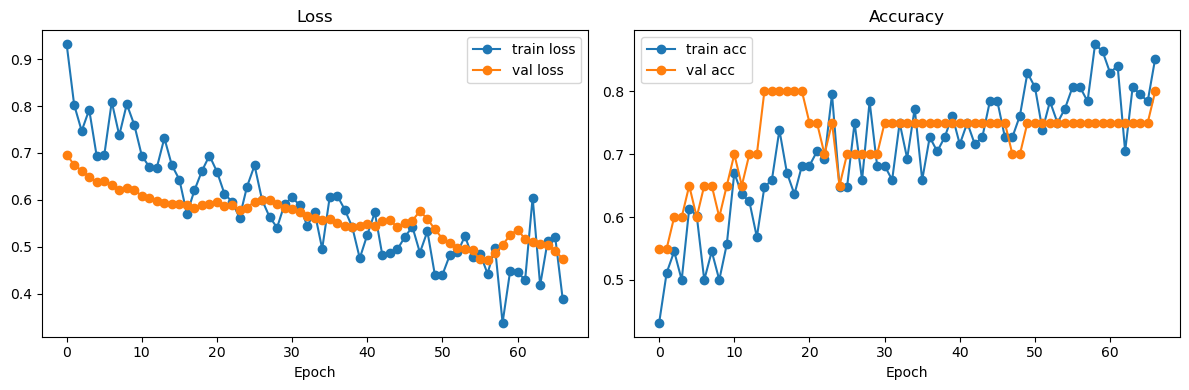

In [106]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()